# Project 2 - Bipartite Graphs
## Moiya Josephs


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi



# Ask
Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?

## Overview

For this project I utilized a dataset found in the "Large-scale Multi-layer Academic Networks (LMANStat)" package. The dataset comprises two Excel files that contain the author and paper information (including author unique id, paper unique id, and the corresponding attributes) and eight CSV files that depict the edge list.

I used the author to paper edgelist for this project and analysis.

### Data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Gaotianchen97/LMANStat/main/Edgelist_author_paper_network.csv")

In [3]:
df

,Target,Source,Year
0,Paper_1,Author_50203,2000
1,Paper_2,Author_33399,2000
2,Paper_2,Author_29791,2000
3,Paper_3,Author_24663,2000
4,Paper_4,Author_43104,2000
...,...,...,...
217769,Paper_97434,Author_53211,2012
217770,Paper_97435,Author_39993,2010
217771,Paper_97435,Author_10595,2010
217772,Paper_97435,Author_70265,2010


To create a bipartite graph, first I will need to create a set from the papers and the authors.

In [4]:
paper = pd.DataFrame(df.Target.unique(),columns = ['Paper'])
author = pd.DataFrame(df.Source.unique(),columns = ['Author'])

In [5]:
paper_list = paper['Paper'].to_list()

In [6]:
author_list = author['Author'].to_list()

Now that the sets are created I will create the Bipartite graph using the `add_nodes_from()` function in the `NetworkX` library.

In [7]:
G = nx.Graph() #create an empty graph
G.add_nodes_from(author_list, bipartite = "authors")
G.add_nodes_from(paper_list, bipartite = "papers")

Inspecting the nodes of the graph with data=True argument we can see the partition being stored.

In [9]:
edges = df[['Target','Source']]

In [10]:
edges_tuple = [tuple(i) for i in edges.values]

In [11]:
G.add_edges_from(edges_tuple)


### Graphing the Data

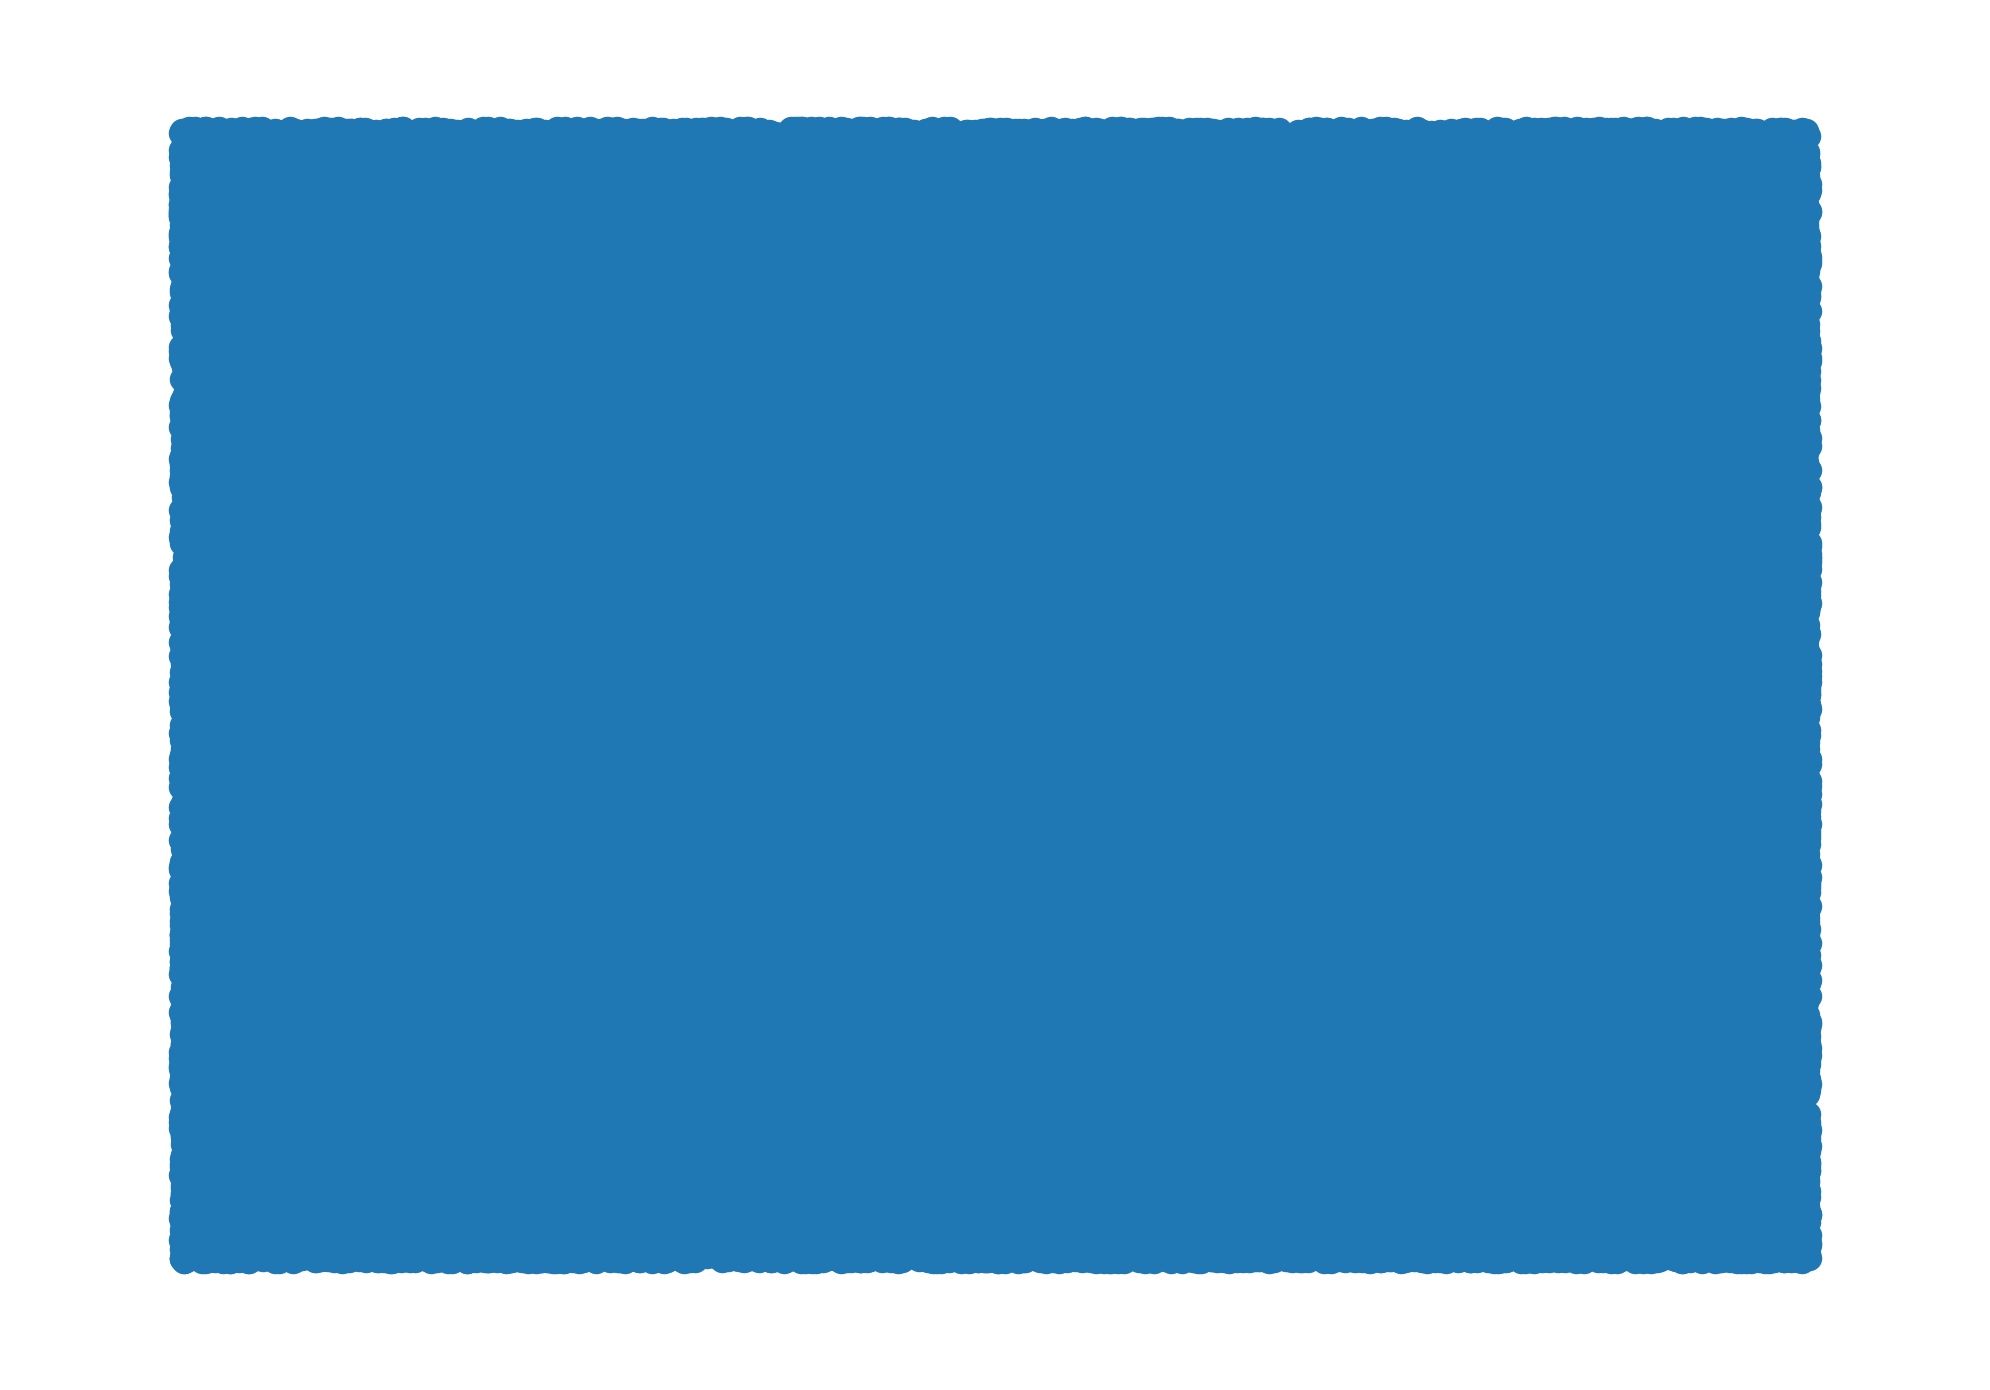

In [12]:
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(G)
nx.draw_networkx_edges(G,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(G, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

In [13]:
nx.is_bipartite(G)

True

When graphing the bipartite graph, we can see that the network is dense. Without further manipulation it is hard to infer any information from the network from this plot alone.

## Implementing Island Method

In order to gleen important information from a large network, I used the island method. The island method creates subgraphs and connections based on nodes weights.

In [14]:
#Code sourced from the Social Network Analysis for Startups 2021 edition
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to,weight = edata)
  return g2

In [15]:
#Code sourced from the Social Network Analysis for Startupds 2021 edition
def island_method(g, iterations=5):
  weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
  mn=int(min(weights))
  mx=int(max(weights))
  #compute the size of the step, so we get a reasonable step in iterations
  step=int((mx-mn)/iterations)
  return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]


## Using the Island Method

The `G` network is not a connected network. There are however 7893 connected subgraphs in this network that could allow for further insights.

In [16]:
nx.is_connected(G)

False

In [17]:
##[len(c) for c in nx.connected_component_subgraphs(G) if len(c) > 10]
A = (G.subgraph(c) for c in nx.connected_components(G))
len(list(A))

7893

In order to utilize the island method defined above, I created two bipartite weighted graphs using the `weighted_projected_graph()` function.

The list below shows the weight or the amount of connections between each author. In the scope of this graph, it emphasizes the authors that collaborated on at least one paper.



### Author's Island

By making the graph a projection of just Author nodes, I am able to properly draw conclusions on the graph.

In [19]:
author_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'authors']
weighted_author_graph = bi.weighted_projected_graph(G, author_nodes)
list(weighted_author_graph.edges(data=True))[0:10]


[('Author_50203', 'Author_13826', {'weight': 7}),
 ('Author_50203', 'Author_69437', {'weight': 1}),
 ('Author_50203', 'Author_4940', {'weight': 1}),
 ('Author_50203', 'Author_65428', {'weight': 1}),
 ('Author_50203', 'Author_56358', {'weight': 1}),
 ('Author_50203', 'Author_57771', {'weight': 3}),
 ('Author_50203', 'Author_41807', {'weight': 1}),
 ('Author_50203', 'Author_25102', {'weight': 1}),
 ('Author_50203', 'Author_2990', {'weight': 2}),
 ('Author_33399', 'Author_29791', {'weight': 1})]

Using the triangles functions, I can see the how many authors are clustered in triangles.

In [33]:
dict((list(nx.triangles(weighted_author_graph).items()))[0:10])

{'Author_50203': 4,
 'Author_33399': 0,
 'Author_29791': 14,
 'Author_24663': 80,
 'Author_43104': 1,
 'Author_6604': 38,
 'Author_19828': 2,
 'Author_5644': 187,
 'Author_52804': 0,
 'Author_1968': 13}

In [ ]:
len(list(nx.connected_components(weighted_author_graph)))

7893

The amount of connected components, or authors that are linked at least once is 7893. This means that there are 7893 networks of authors who collobarated on a paper together in this network.

A preview of the degree centrality for the author nodes are shown below.

In [25]:
dict((list(nx.degree_centrality(weighted_author_graph).items()))[0:10])


{'Author_50203': 0.000127237255068284,
 'Author_33399': 1.4137472785364888e-05,
 'Author_29791': 0.0004241241835609466,
 'Author_24663': 0.0008058359487657986,
 'Author_43104': 2.8274945570729776e-05,
 'Author_6604': 0.00040998671077558177,
 'Author_19828': 5.654989114145955e-05,
 'Author_5644': 0.0013289224418242995,
 'Author_52804': 1.4137472785364888e-05,
 'Author_1968': 0.000254474510136568}

In [ ]:
[len(c) for c in nx.connected_components(weighted_author_graph) if len(c) > 10][0:10]

[54112, 17, 15, 12, 14, 19, 11, 13, 12, 15]

Additionally, the author's graph is not connected. This shows that there is no common paper in which all authors worked together.

By using list comprehension, I am able to see the different connected components in the graph. The largest graph's connected component has 54112 components.

There is however one giant component that has > 54,000 components. According to the textbook, we can treat this giant component as the whole network. This component is the first one listed when using the `connected_components` function.

In [ ]:
S = [weighted_author_graph.subgraph(c).copy() for c in nx.connected_components(weighted_author_graph)]

In [ ]:
nx.is_connected(S[0])

True

Now I can use the island method on this connected component to analyze this large network closer.

In [ ]:
island_authors = island_method(S[0])

In [ ]:
for i in island_authors:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))


Threshold: 1 Size: 16667 Connections: 1250
Threshold: 13 Size: 304 Connections: 121
Threshold: 25 Size: 35 Connections: 16
Threshold: 37 Size: 10 Connections: 5
Threshold: 49 Size: 6 Connections: 3
Threshold: 61 Size: 2 Connections: 1


By using the `island_method` I was able to divide by 6 thresholds. This threshold can be specified in the function, but for this project I will keep it simple.

Next I created islands at the first threshold.
The first threshold has 1,250 connections (also known as edges) and the graph's size was 16,667 nodes.

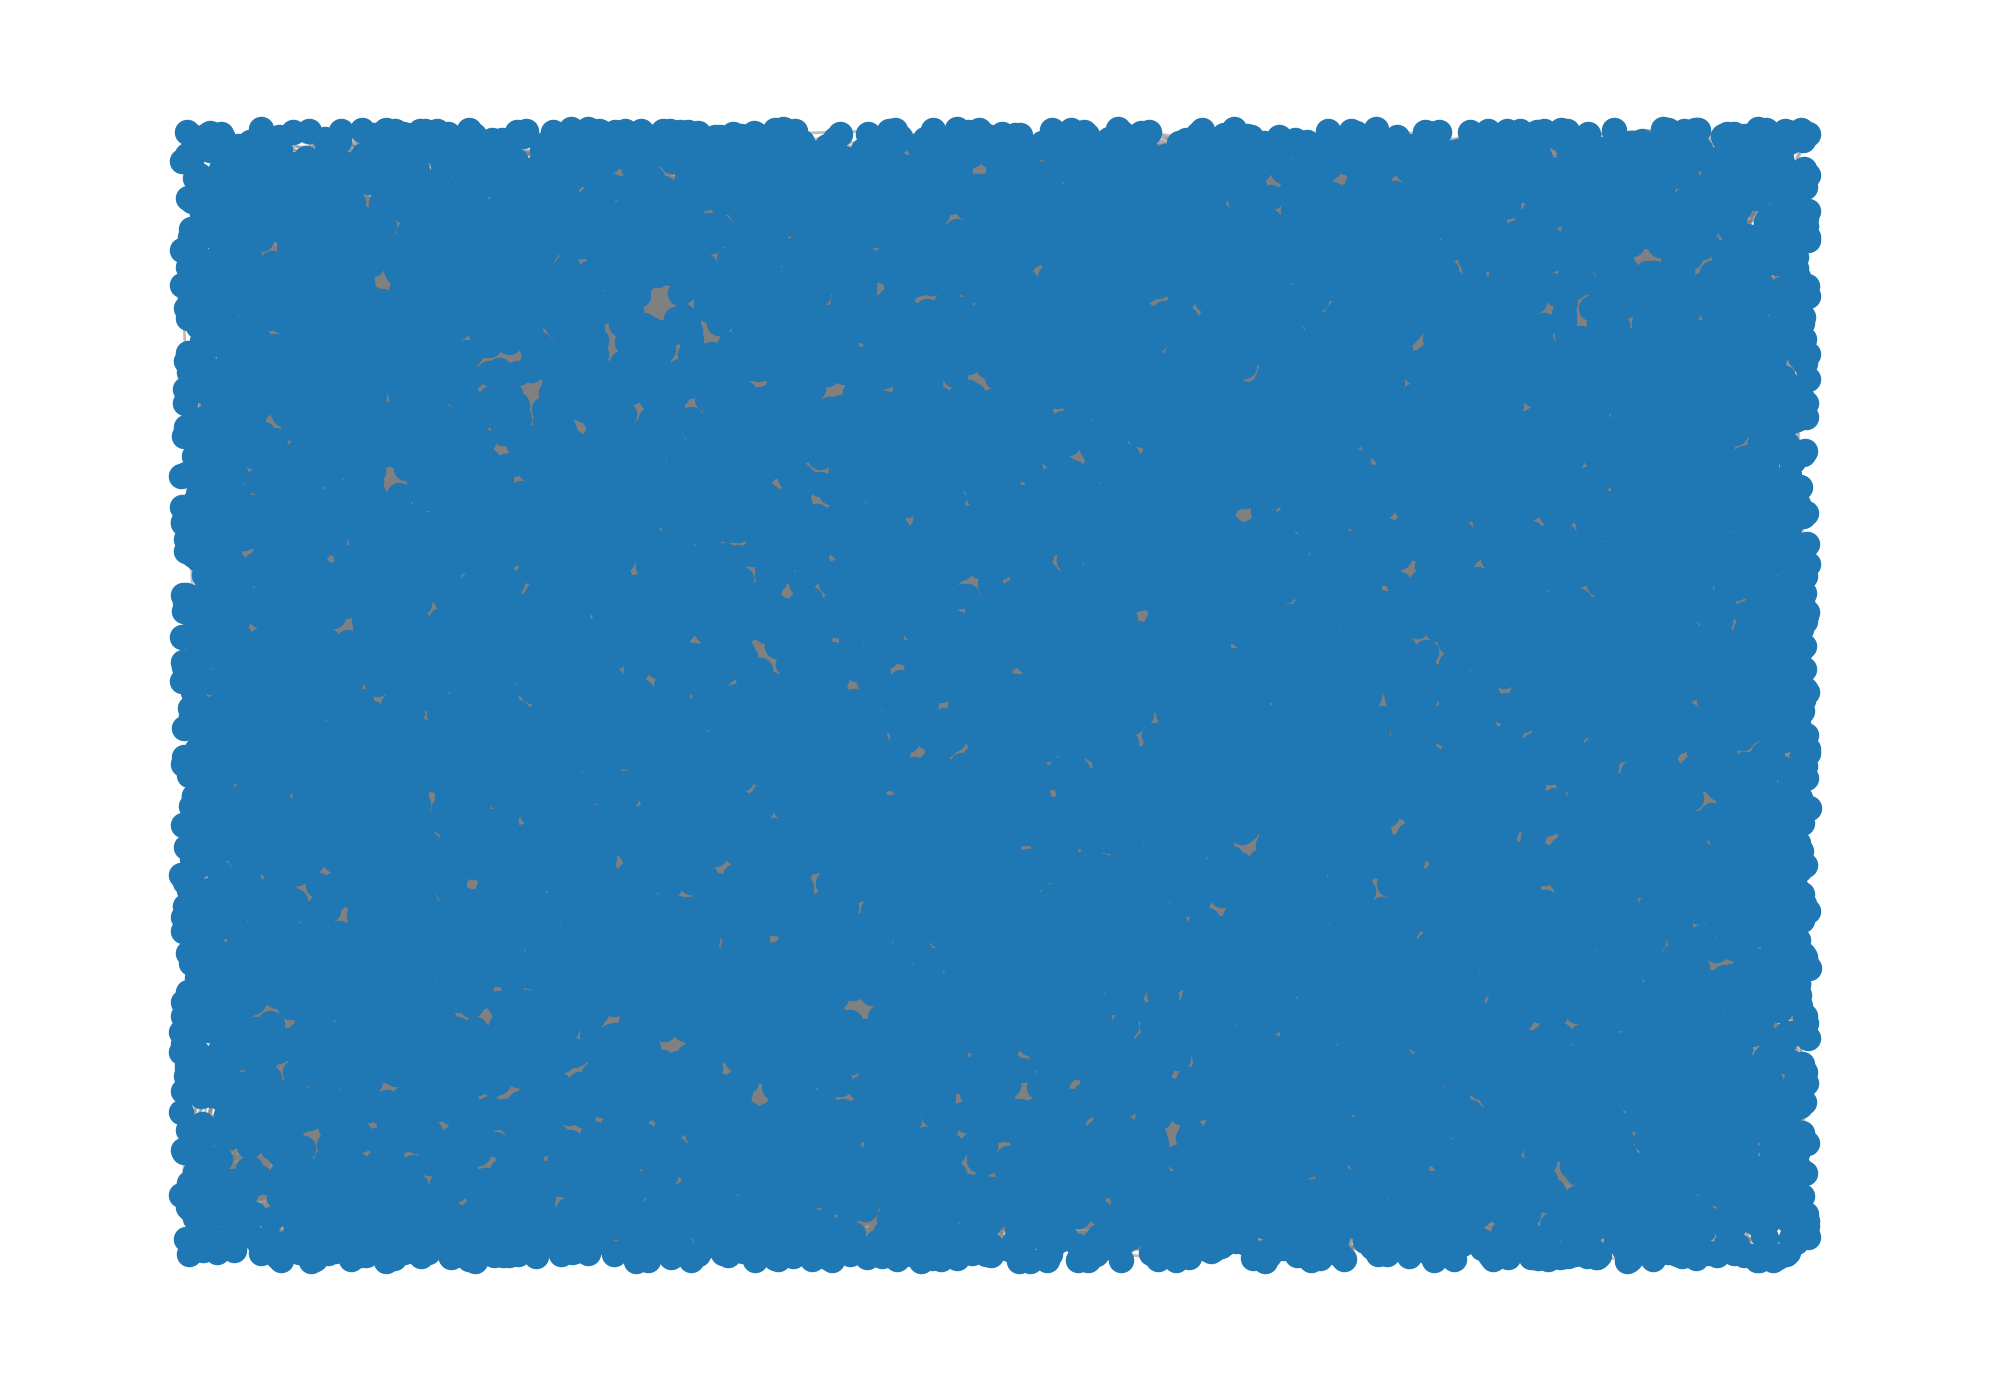

In [ ]:
subgraph = island_authors[0][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

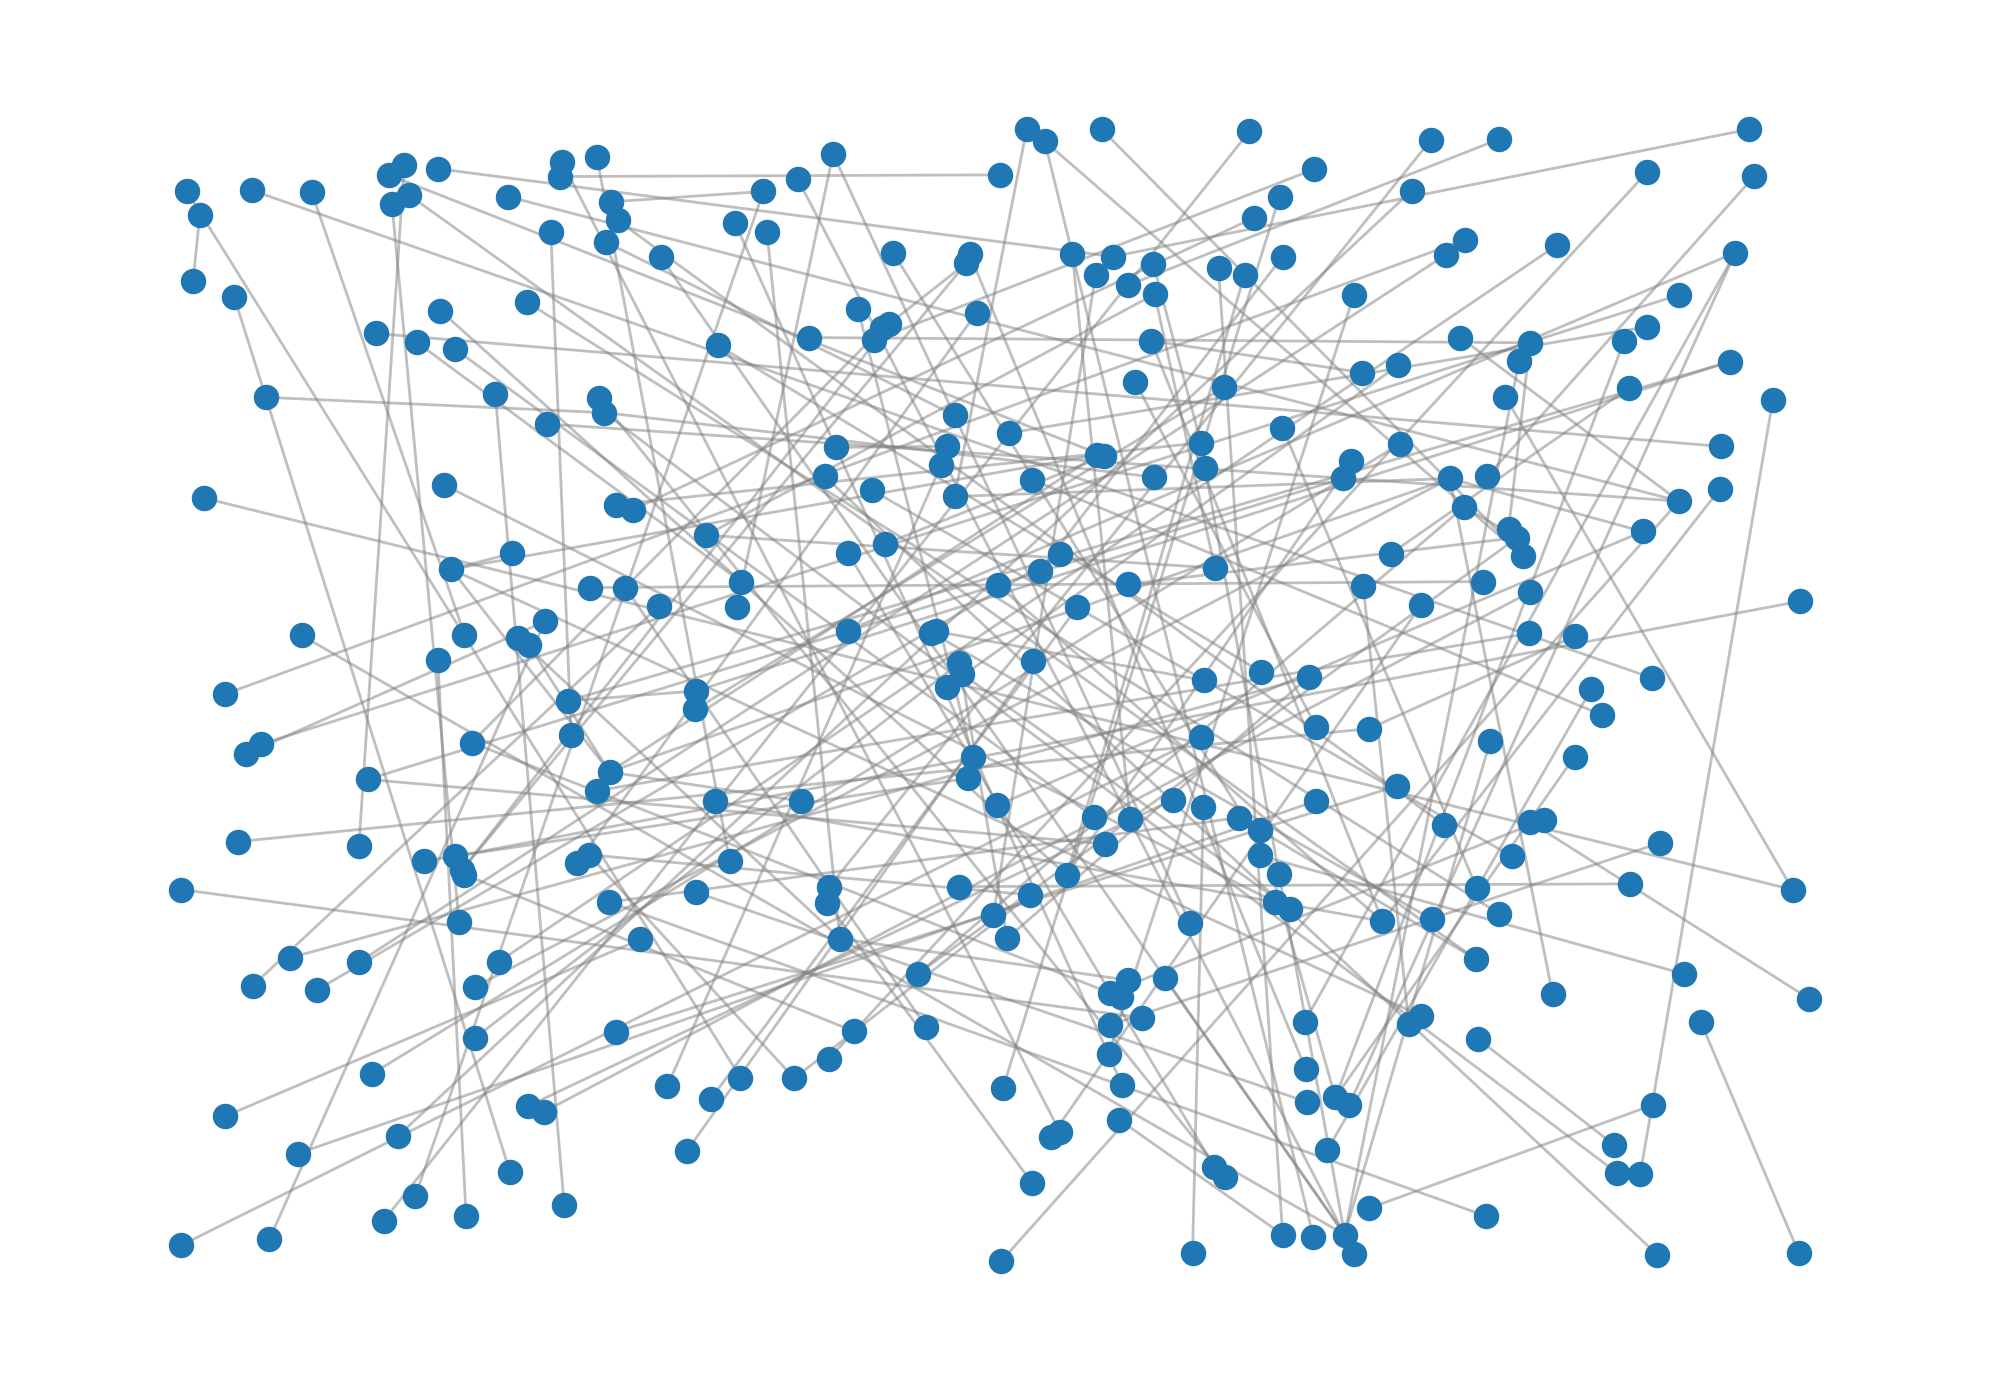

In [ ]:
subgraph = island_authors[1][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At the next threshold (shown above), the graph is less dense but it is still not enough to make any visual conclusions from.

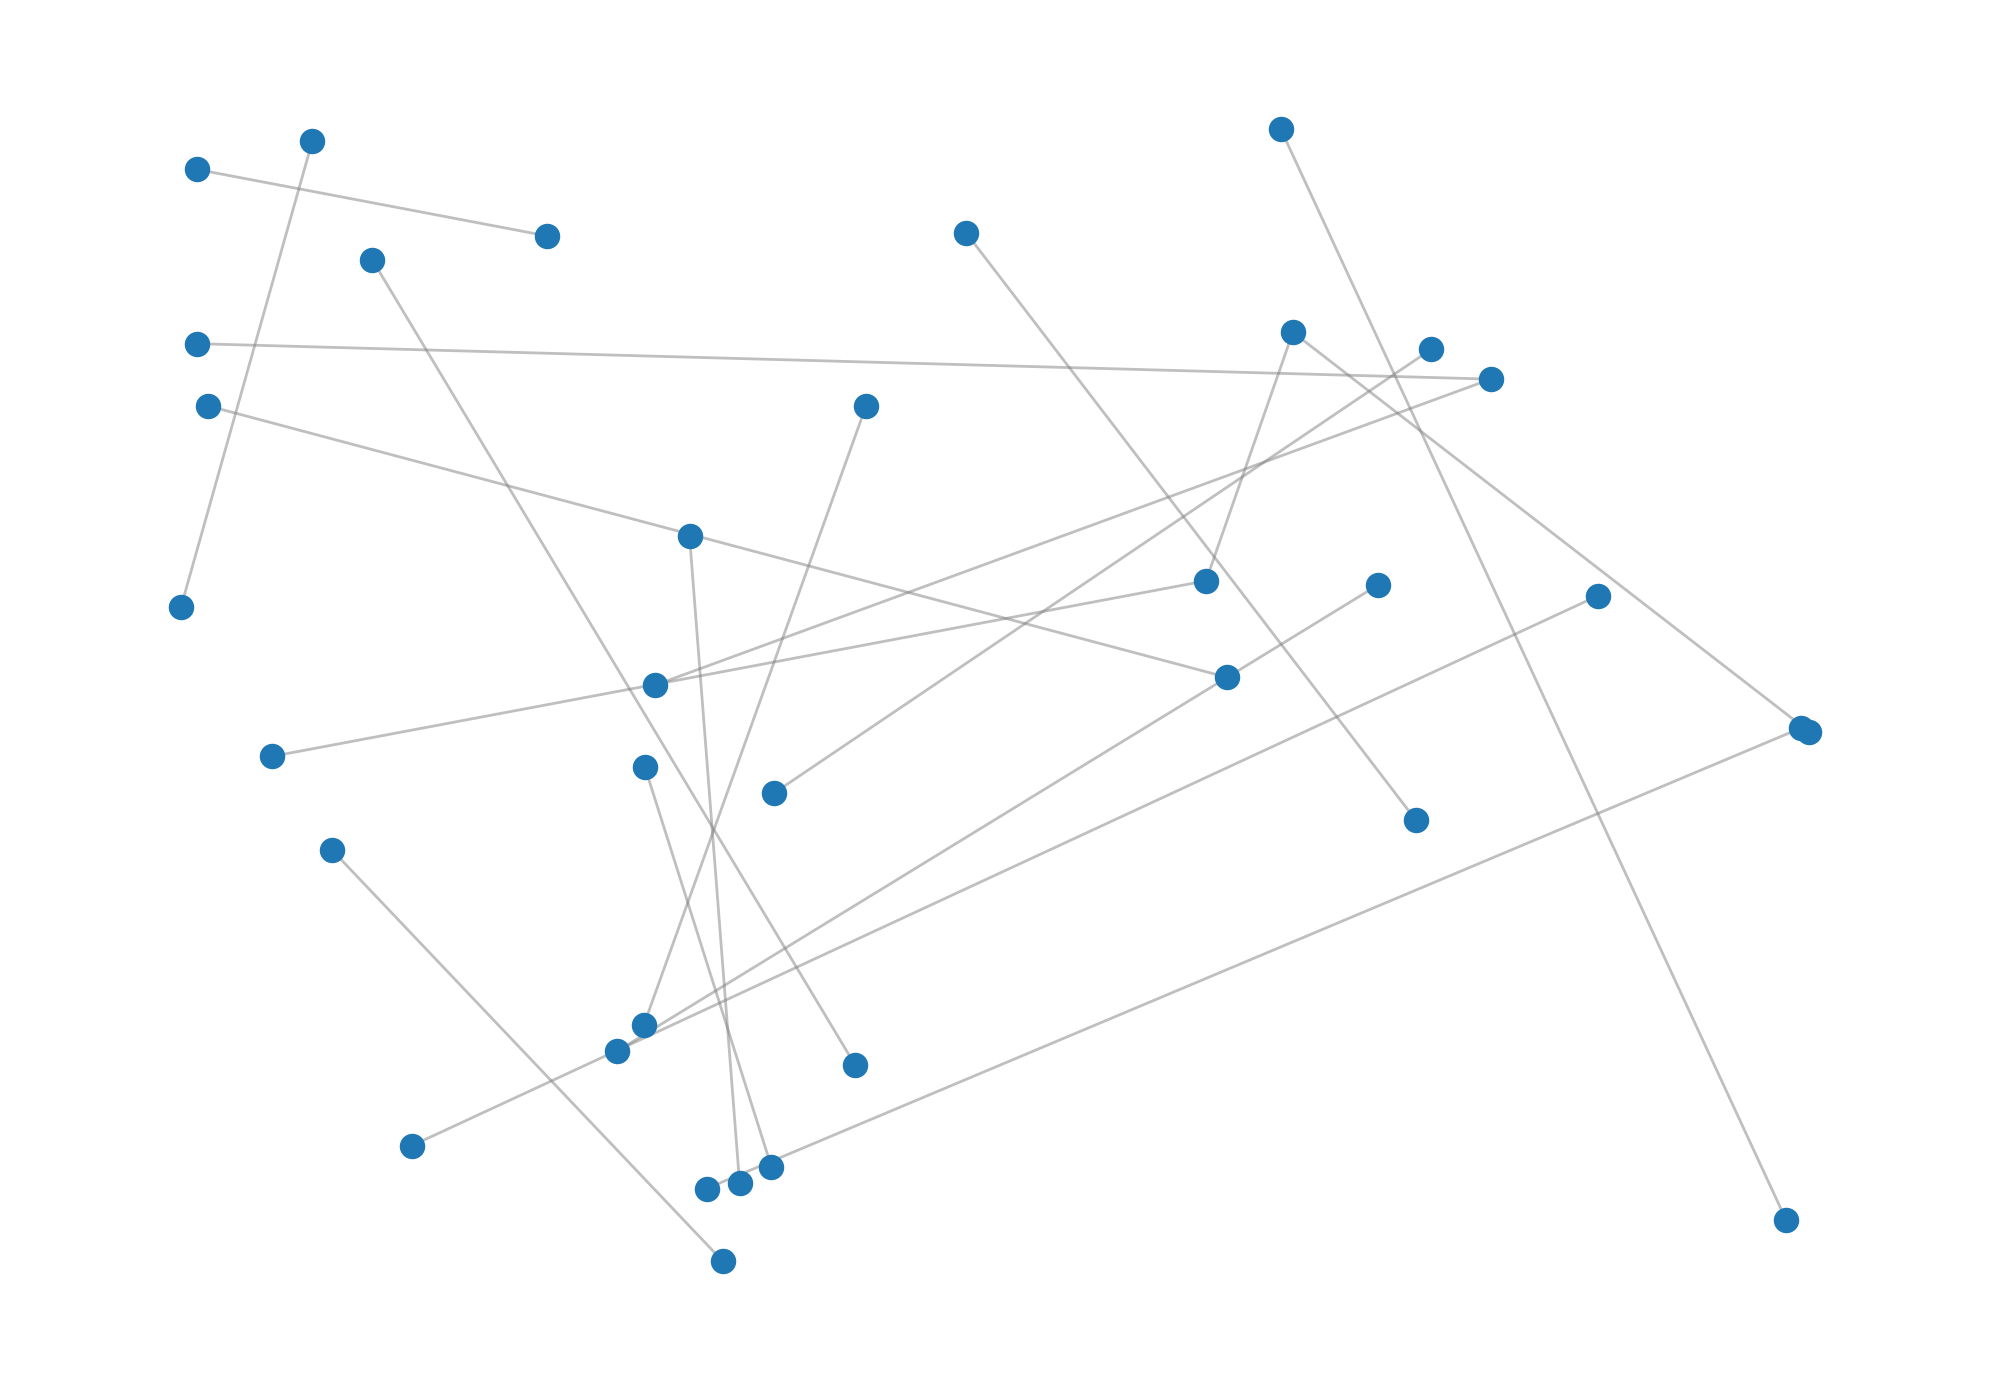

In [ ]:
subgraph = island_authors[2][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At this threshold (shown above) we can see more of the island and connections and draw more visual conclusions. There are examples of islands that have 4 nodes and as small as two nodes.

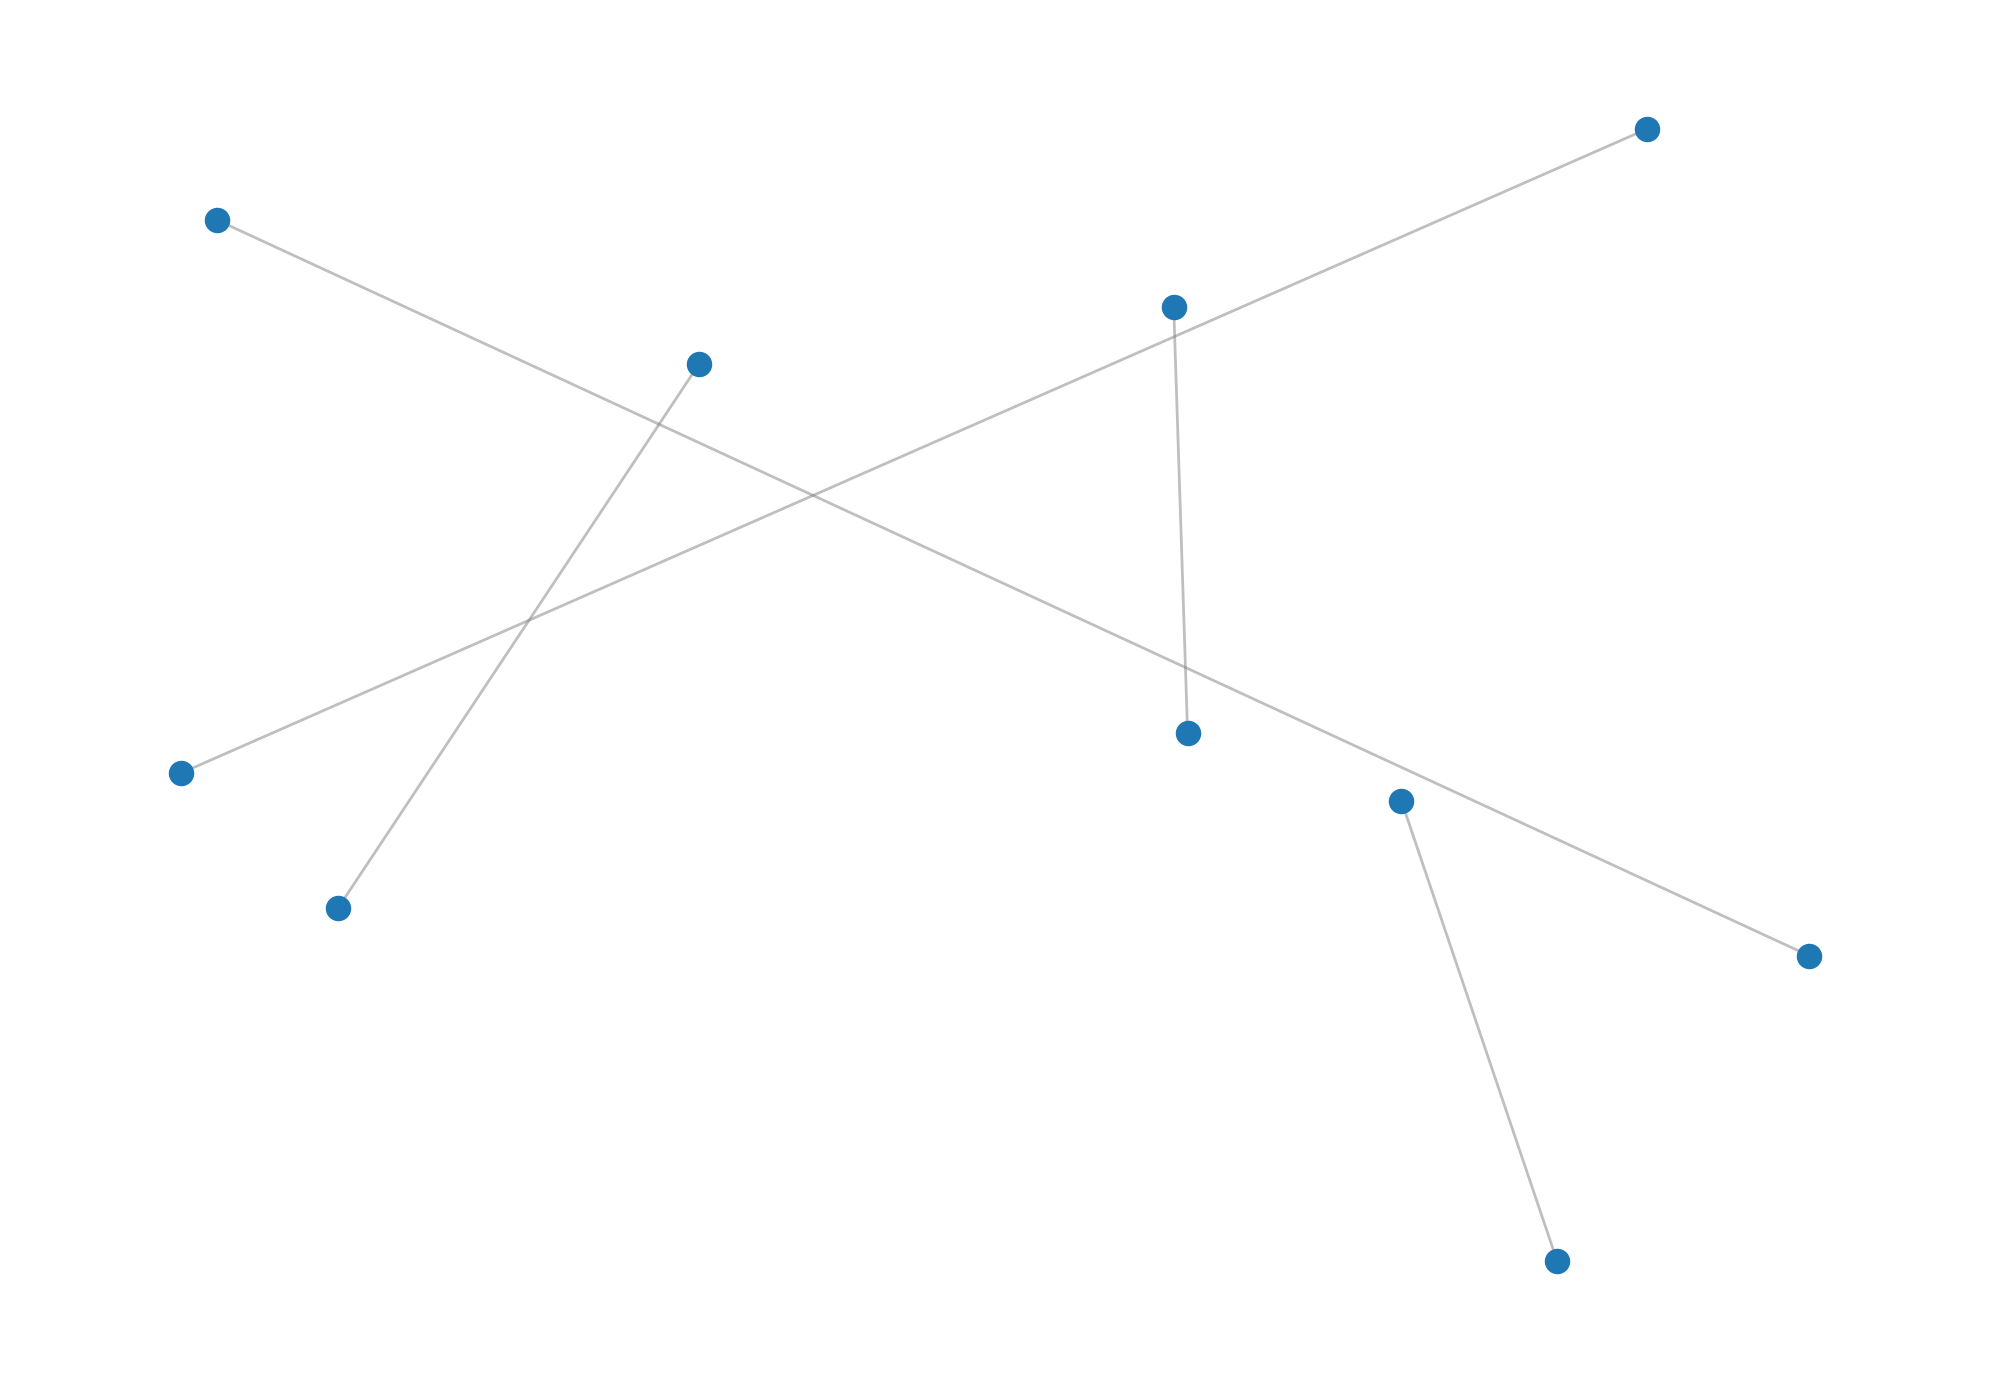

In [ ]:
subgraph = island_authors[3][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

The higher the threshold, the less connections we can see between the author nodes. Here all of the islands have two nodes only.

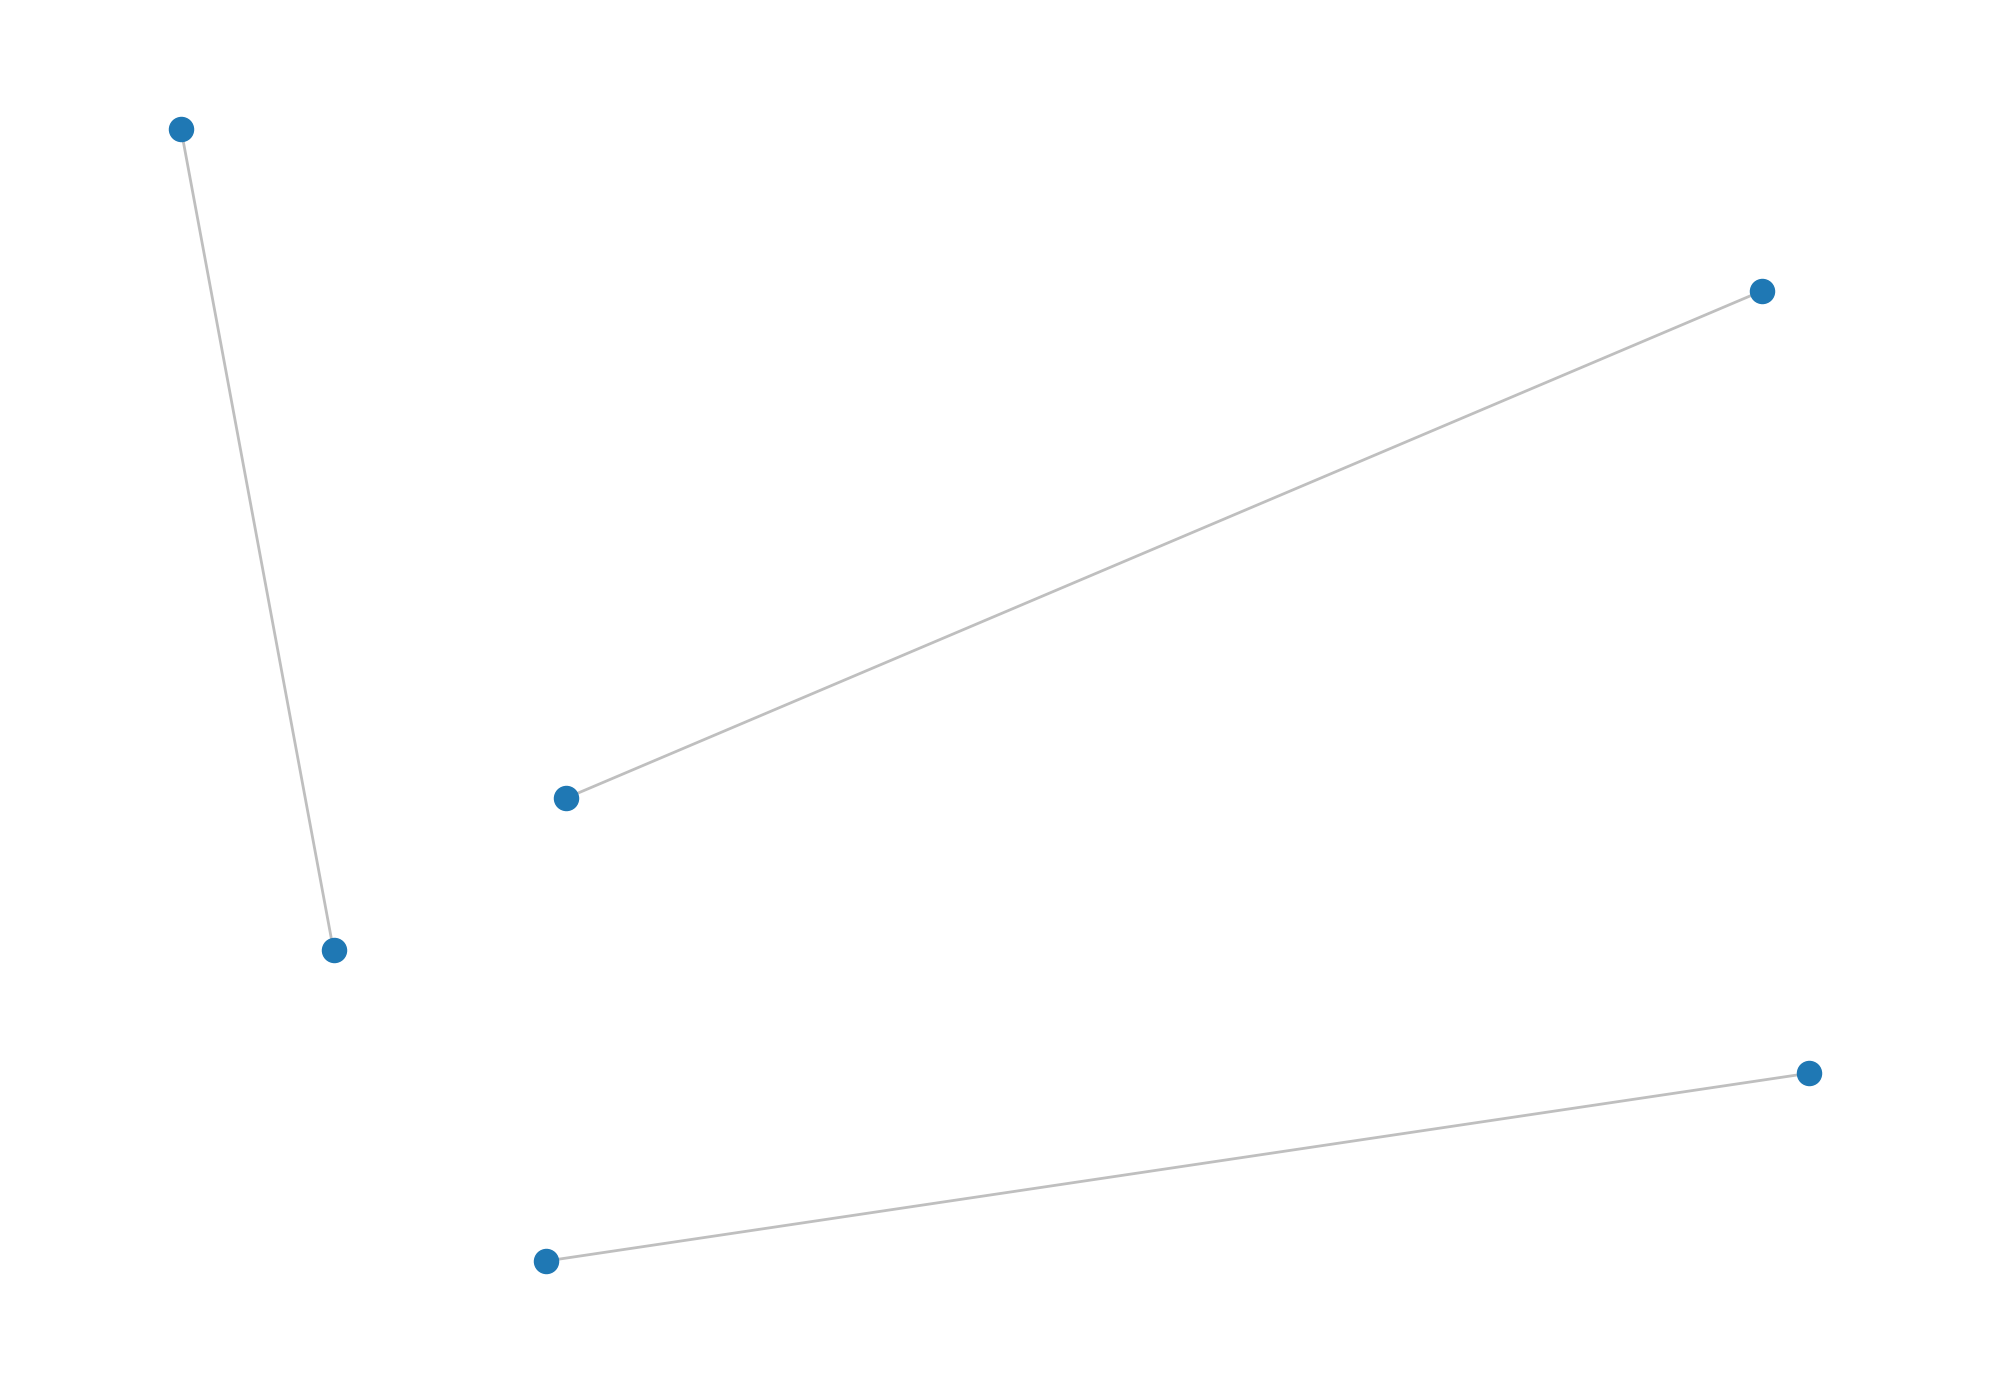

In [ ]:
subgraph = island_authors[4][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

This second to last threshold only shows two islands.

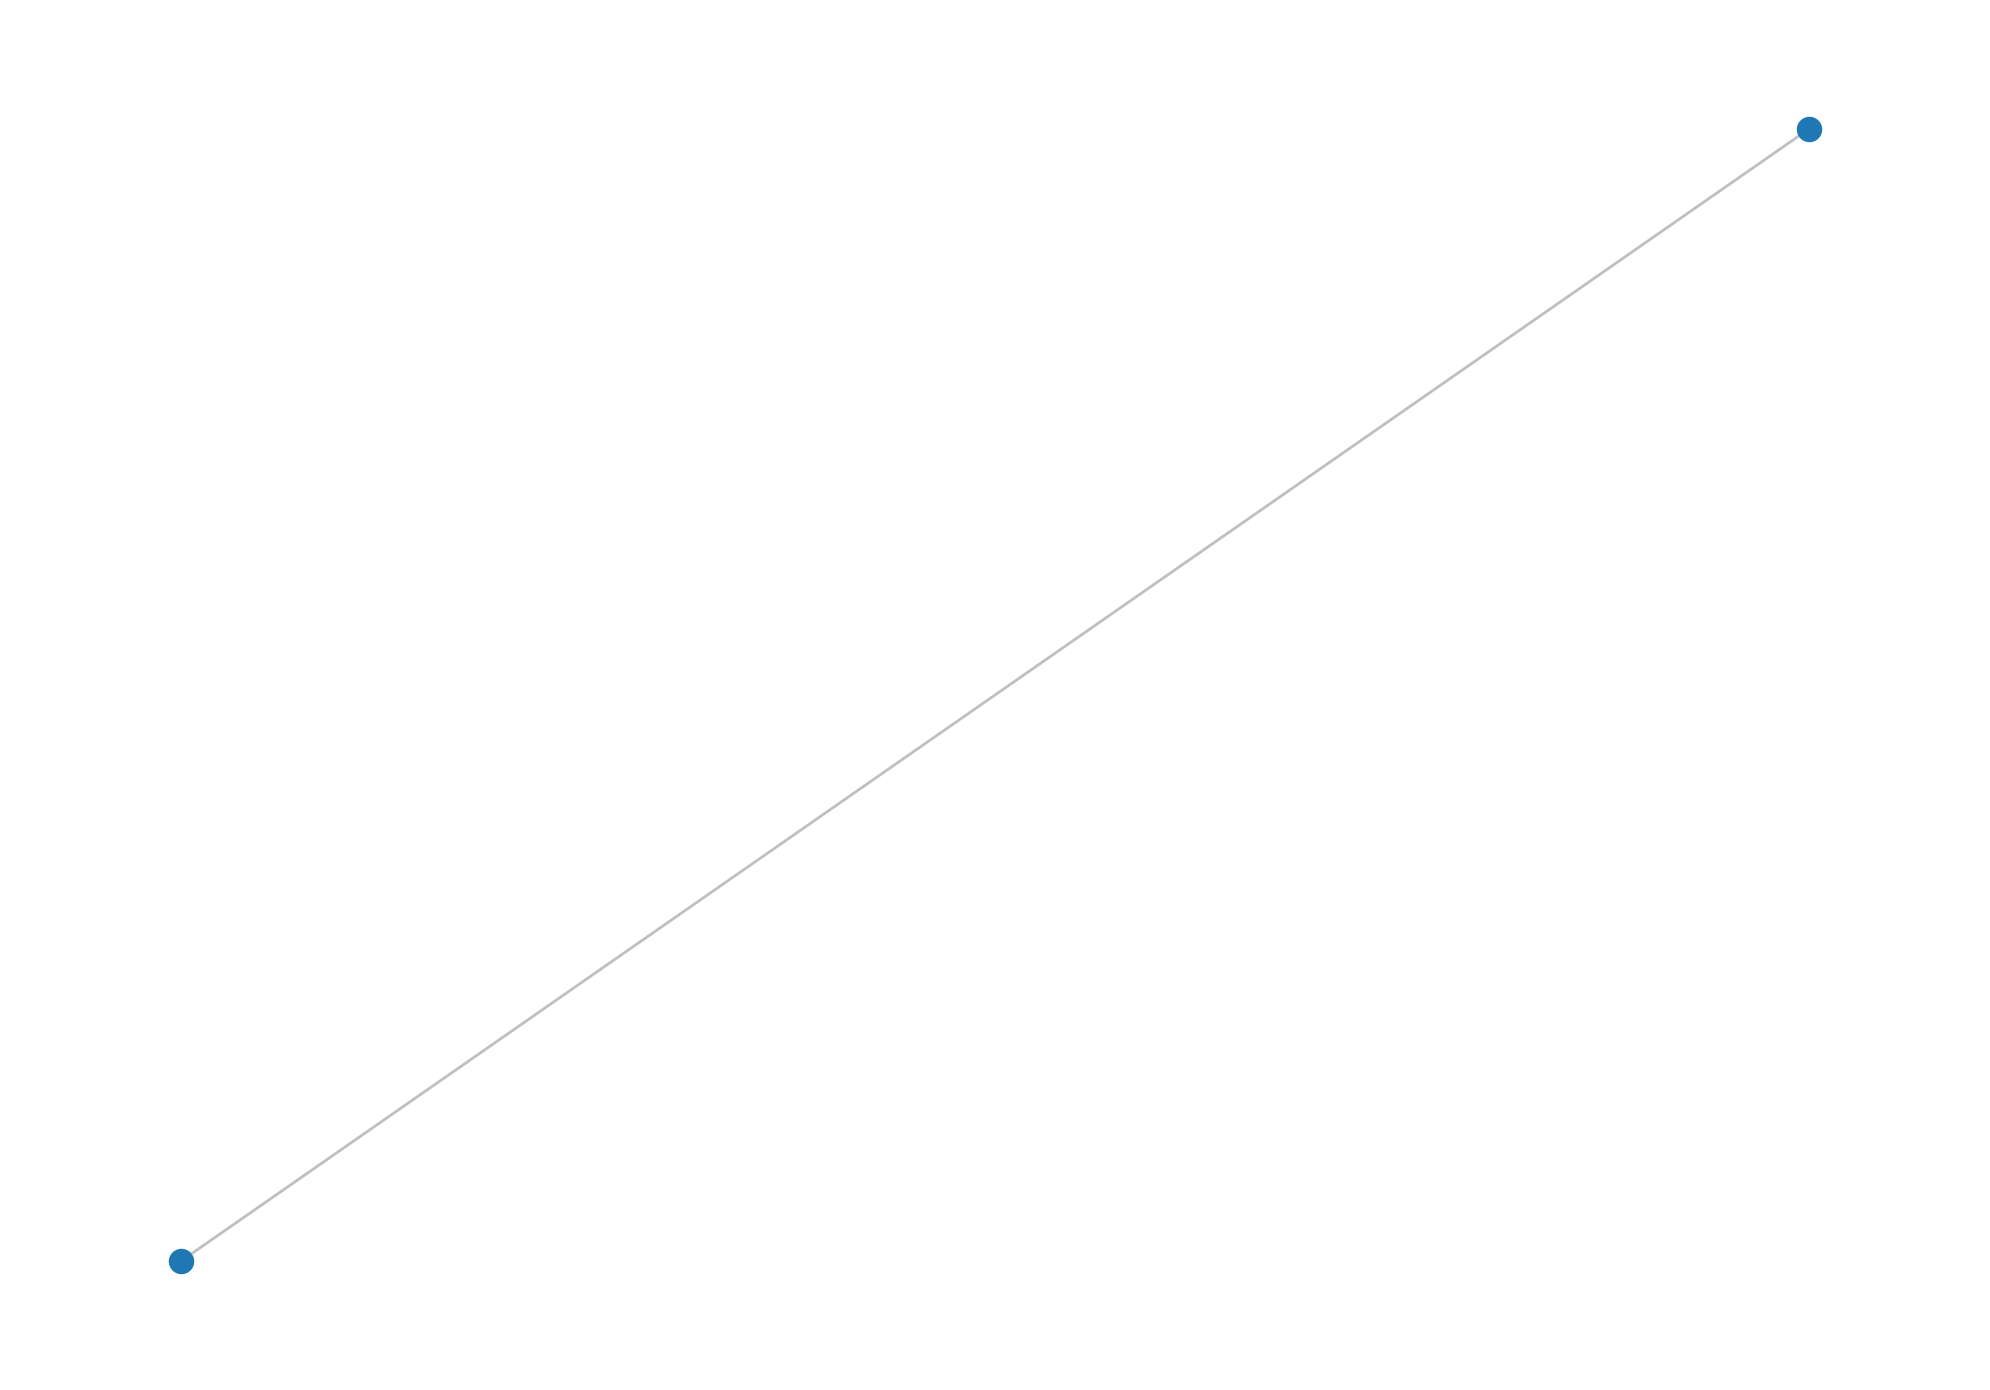

In [ ]:
subgraph = island_authors[5][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

The island graph shows that there are authors who are connected to the same papers. The initial graph `G` was too dense to visually see any connections between authors. With the use of the island method we are able to see the connections clearer. This analysis shows that the greatest number of authors connected to a single paper is 1250 when the threshold is of a weight 1.

### Papers' Island

Next I will apply the same methodology I did for the Author nodes to the paper nodes.

In [34]:
paper_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'papers']
weighted_paper_graph = bi.weighted_projected_graph(G, paper_nodes)
list(weighted_paper_graph.edges(data=True))[0:20]

[('Paper_1', 'Paper_40702', {'weight': 1}),
 ('Paper_1', 'Paper_36872', {'weight': 1}),
 ('Paper_1', 'Paper_79482', {'weight': 1}),
 ('Paper_1', 'Paper_9815', {'weight': 1}),
 ('Paper_1', 'Paper_10028', {'weight': 1}),
 ('Paper_1', 'Paper_63176', {'weight': 1}),
 ('Paper_1', 'Paper_40001', {'weight': 1}),
 ('Paper_1', 'Paper_9361', {'weight': 1}),
 ('Paper_1', 'Paper_28147', {'weight': 1}),
 ('Paper_1', 'Paper_9573', {'weight': 1}),
 ('Paper_1', 'Paper_39999', {'weight': 1}),
 ('Paper_1', 'Paper_16394', {'weight': 1}),
 ('Paper_1', 'Paper_8484', {'weight': 1}),
 ('Paper_1', 'Paper_23908', {'weight': 1}),
 ('Paper_1', 'Paper_64223', {'weight': 1}),
 ('Paper_1', 'Paper_24278', {'weight': 1}),
 ('Paper_1', 'Paper_77662', {'weight': 1}),
 ('Paper_1', 'Paper_38586', {'weight': 1}),
 ('Paper_1', 'Paper_44301', {'weight': 1}),
 ('Paper_1', 'Paper_96984', {'weight': 1})]

There are 7893 connected components in the weighted paper graph.

In [35]:
len(list(nx.connected_components(weighted_paper_graph)))

7893

In [40]:
paper_triangles = nx.triangles(weighted_paper_graph)

In [36]:
dict((list(paper_triangles.items()))[0:10])

{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The weighted paper graph shows that there are triangles in this projections. The paper with the maximum amount of triangles it was apart of is Paper 8394.

In [49]:
max(paper_triangles, key= lambda x: paper_triangles[x])

'Paper_83294'

The degree centrality is saved to `paper_dc`.

In [47]:
paper_dc = nx.degree_centrality(weighted_paper_graph)

In [48]:
max(paper_dc, key= lambda x: paper_dc[x])

'Paper_83294'

The paper with the maximum degree centrality is again Paper 83294.

In [42]:
dict((list(paper_triangles.items()))[0:10])


{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The degree centrality shows the importance of each nodes by the number of connections it has.

In [38]:
[len(c) for c in nx.connected_components(weighted_paper_graph) if len(c) > 10][0:10]

[84407, 18, 23, 19, 17, 18, 21, 16, 12, 11]

The largest connected subgraph has 88407 components in it.

In [ ]:
S = [weighted_paper_graph.subgraph(c).copy() for c in nx.connected_components(weighted_paper_graph)]

Utilizing the island method with a threshold of 5, we show at least 6 different graphs below.

In [ ]:
island_papers = island_method(S[0])

In [ ]:
island_papers

[[1, <networkx.classes.graph.Graph at 0x799e7365fc70>],
 [5, <networkx.classes.graph.Graph at 0x799e35463f40>],
 [9, <networkx.classes.graph.Graph at 0x799e74a19f90>],
 [13, <networkx.classes.graph.Graph at 0x799e74a18f70>],
 [17, <networkx.classes.graph.Graph at 0x799e74a18a00>],
 [21, <networkx.classes.graph.Graph at 0x799e74a19750>]]

In [ ]:
for i in island_papers:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))

Threshold: 1 Size: 41452 Connections: 8244
Threshold: 5 Size: 41 Connections: 18
Threshold: 9 Size: 2 Connections: 1
Threshold: 13 Size: 2 Connections: 1
Threshold: 17 Size: 2 Connections: 1
Threshold: 21 Size: 2 Connections: 1


When using the island method on the papers graph, we see that there are very few components with connections larger than 1. Only at the first two thresholds do we see multiple connections. The largest paper network is at threshold 1. In the context of this network, a paper's connection indicates that it was written by the same author.

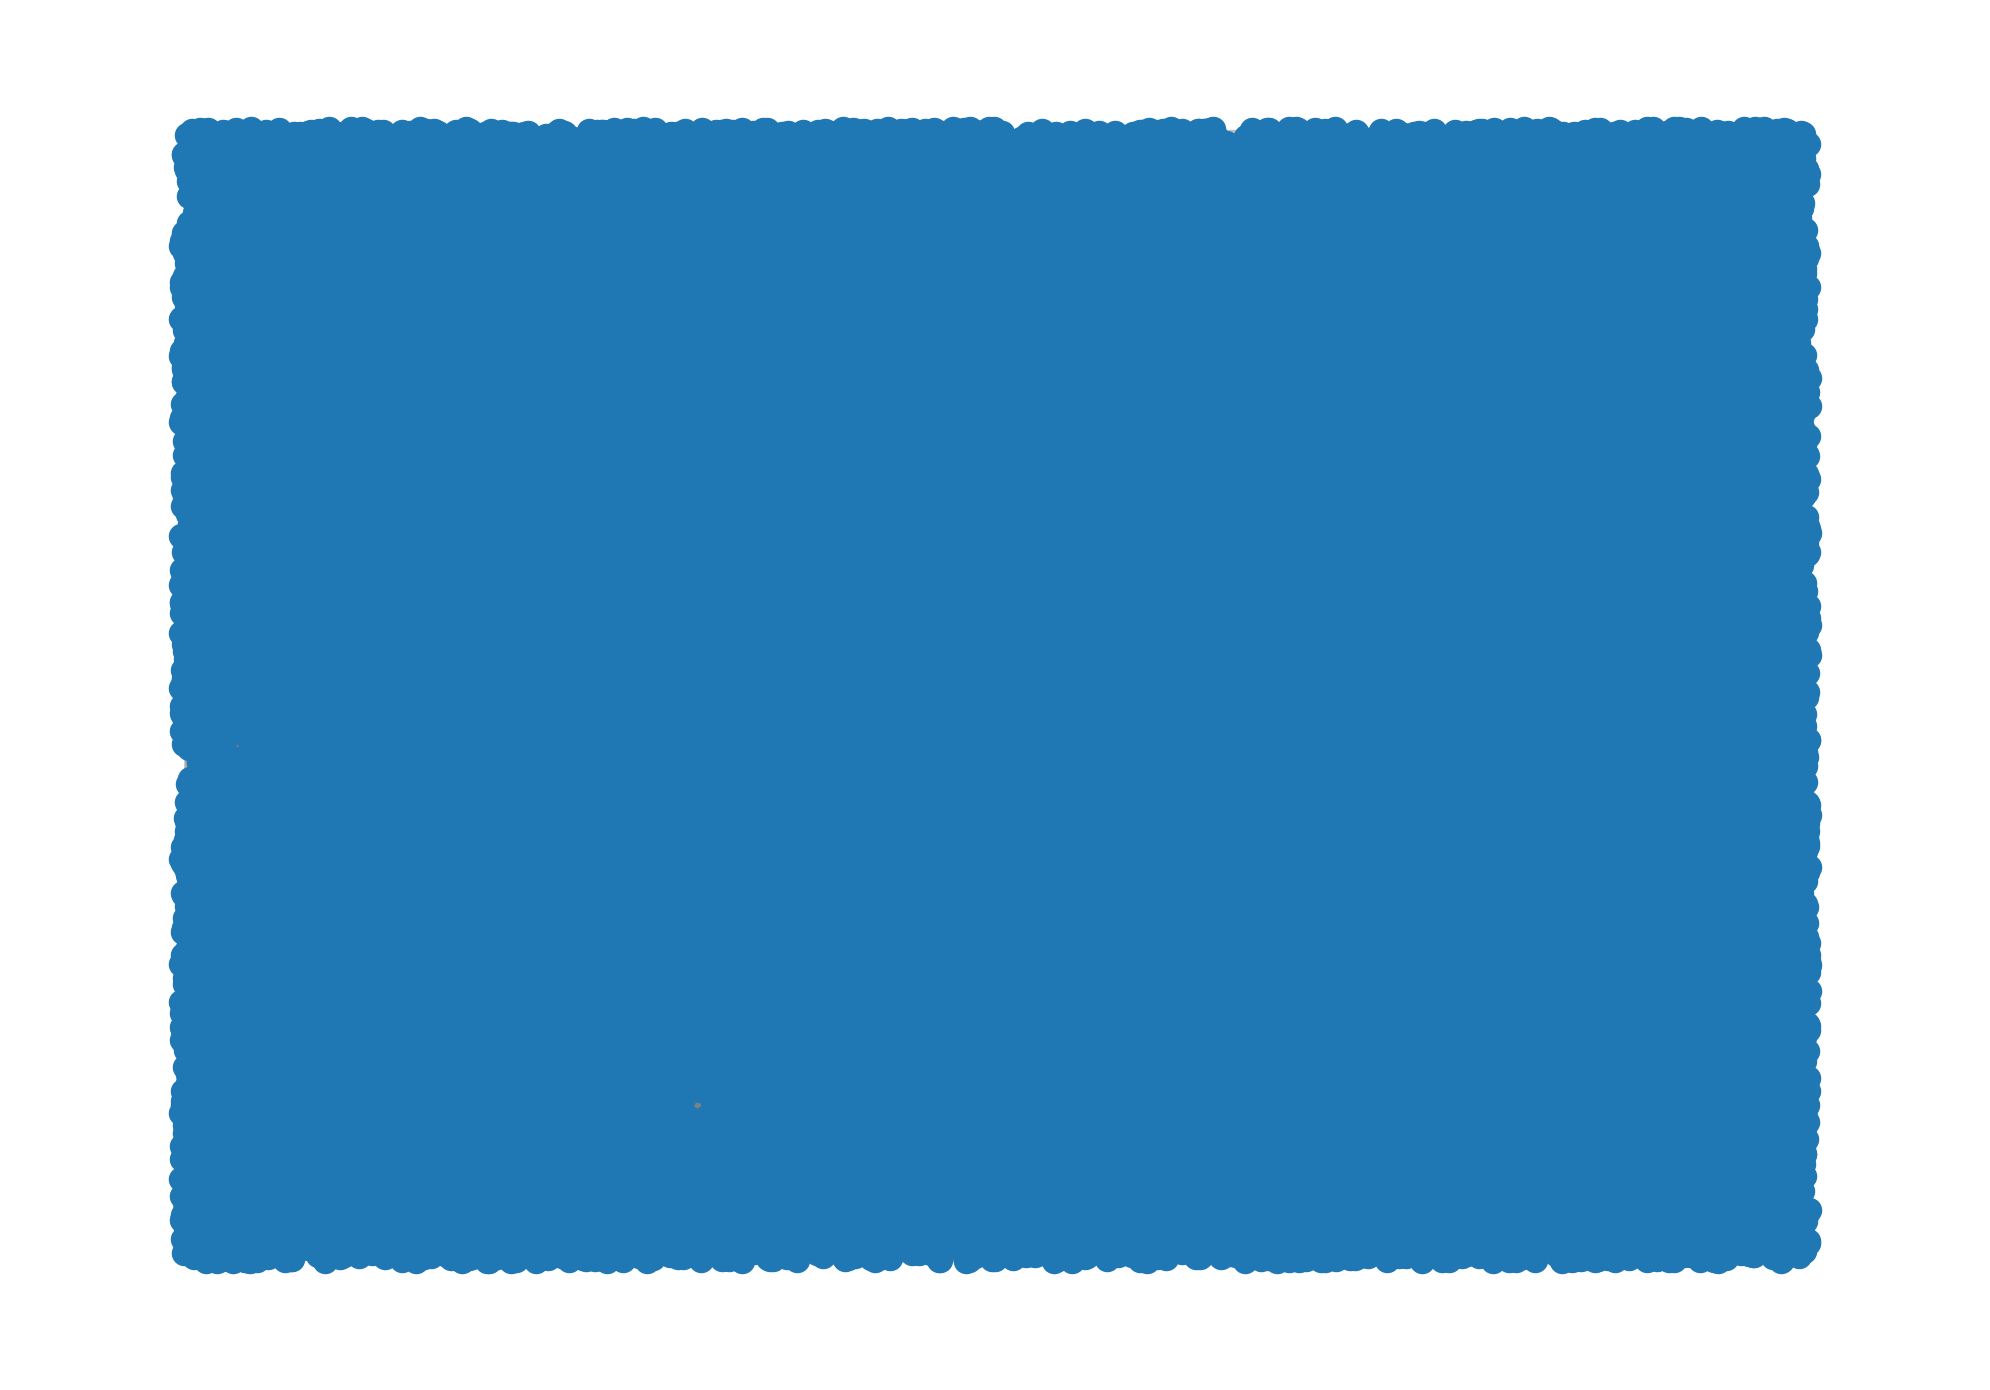

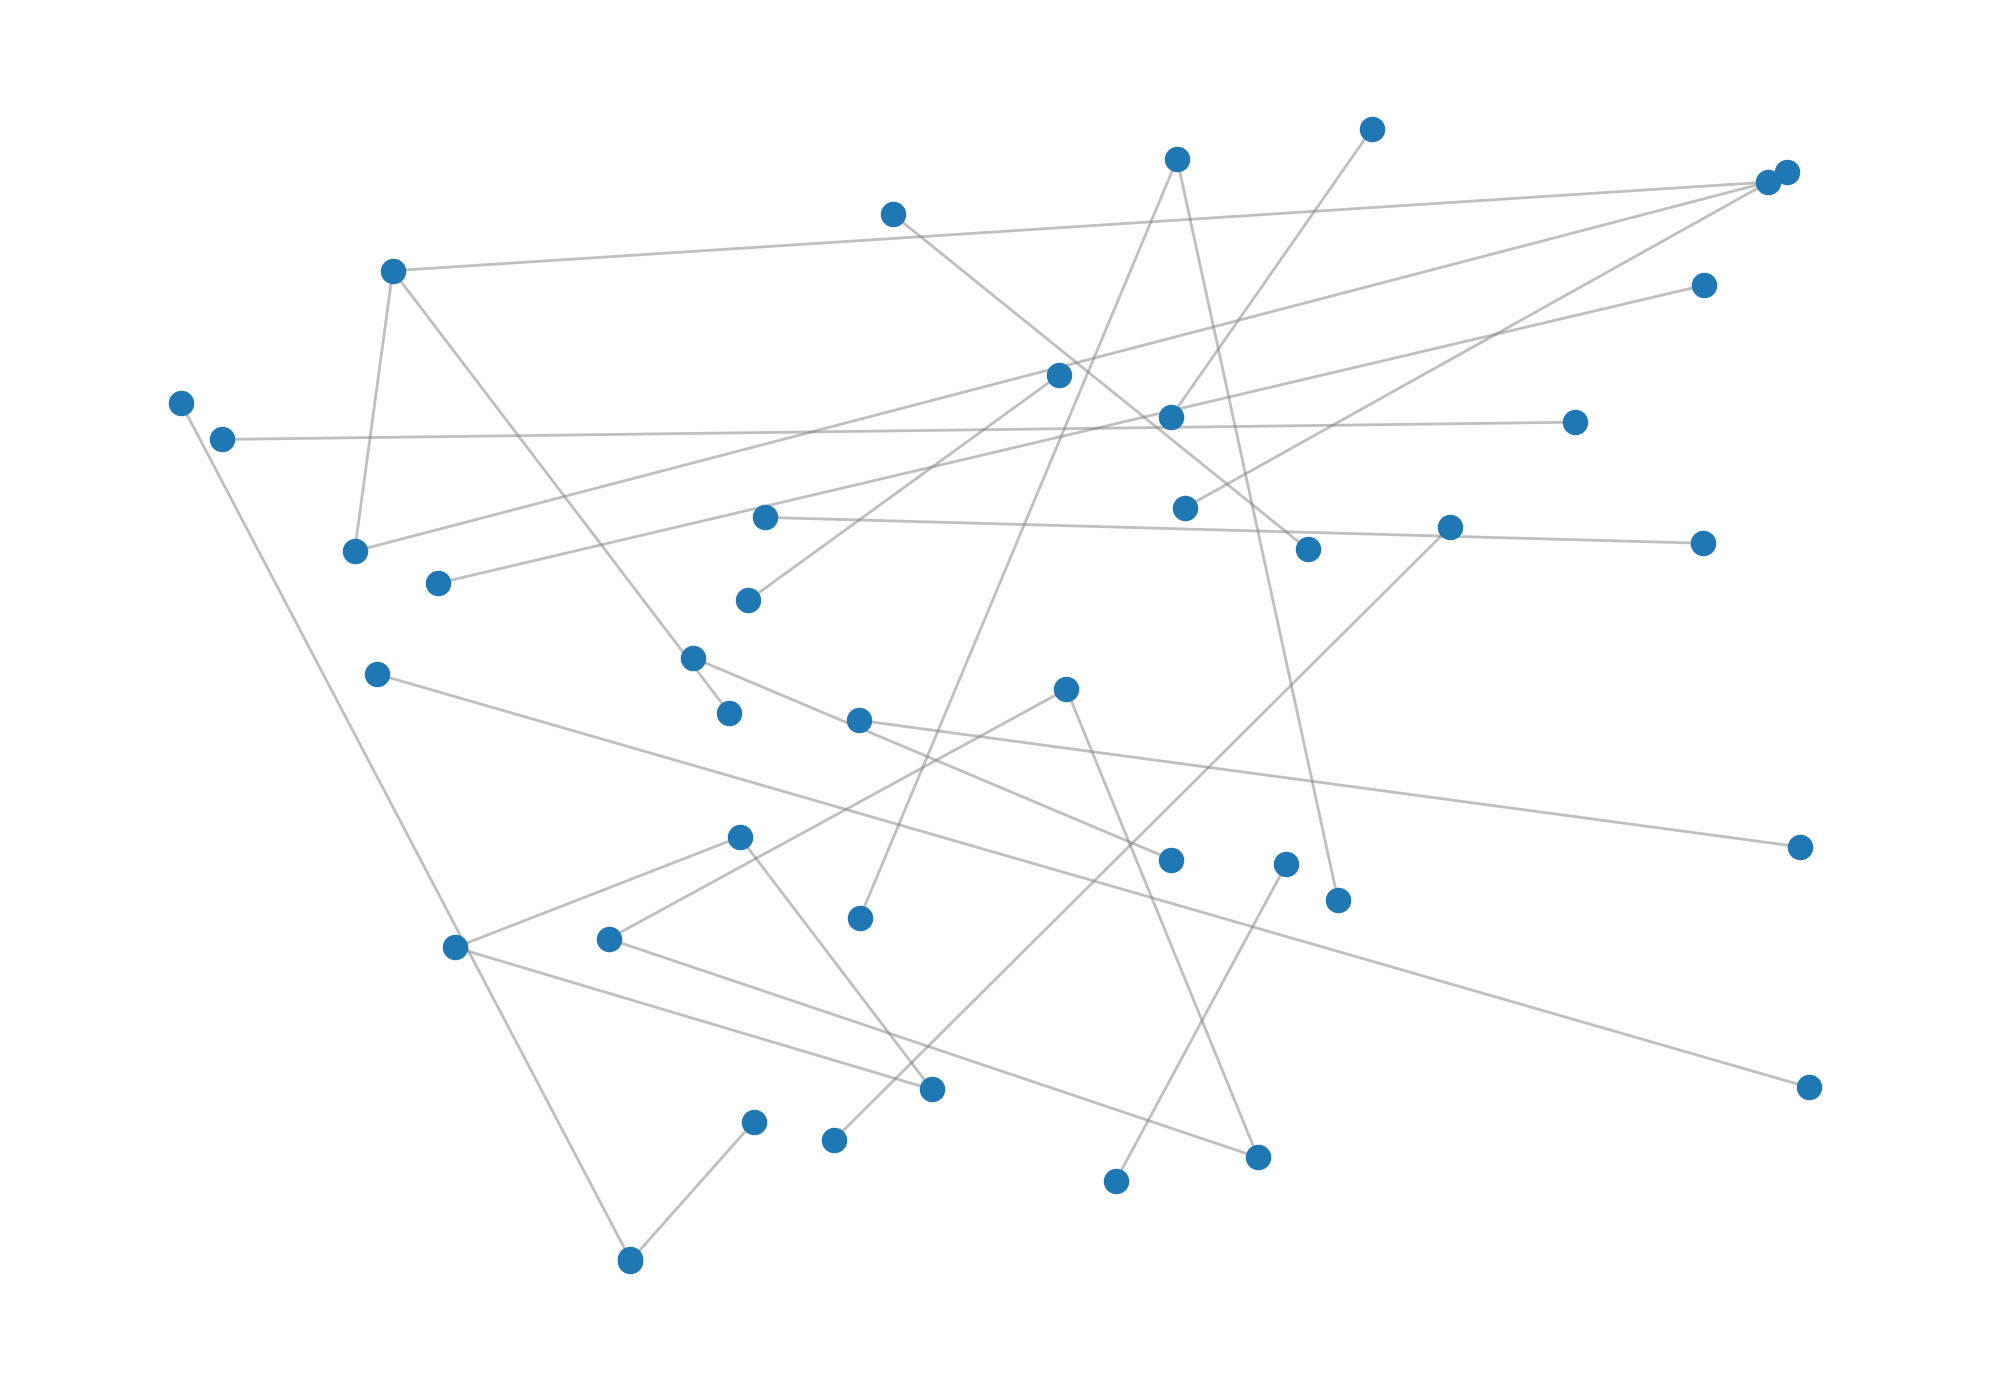

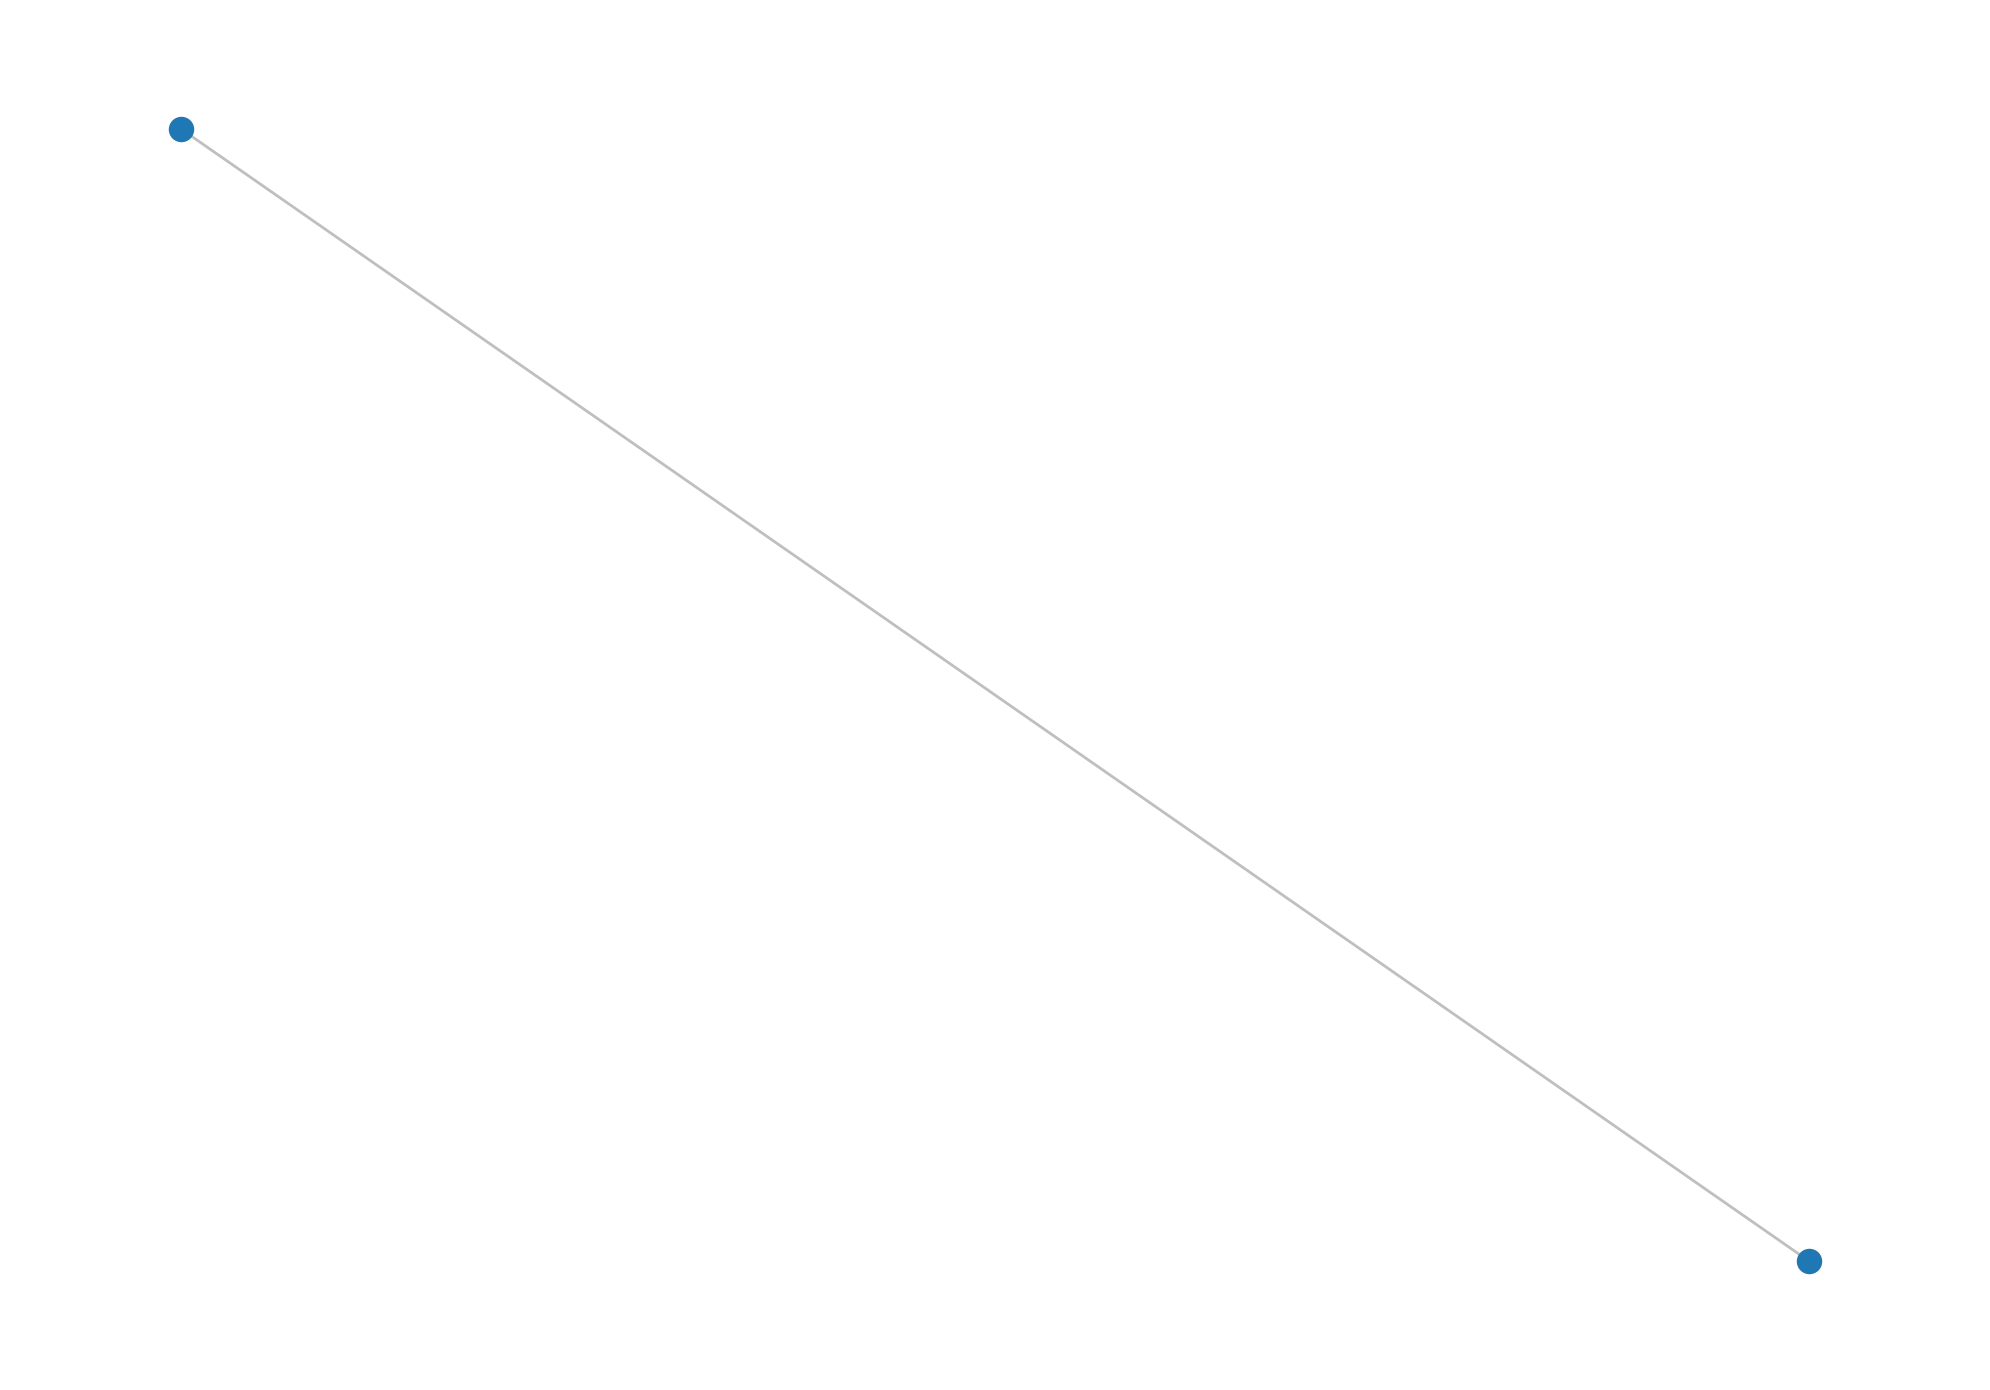

In [ ]:
for i in range(3):
  subgraph = island_papers[i][1]
  # set figure size
  plt.figure(figsize=(20,14))
  # determine the positions using spring layout
  pos = nx.random_layout(subgraph)
  nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
      alpha=0.5,width=2)


  # nx.draw(g,pos)
  nx.draw_networkx_nodes(subgraph, pos)
  # set tight layout
  plt.tight_layout()
  # remove axis
  plt.axis('off')

  plt.show()

Again we see a very dense graph at the first threshold. The higher the threshold the smaller the graphs become. This is a notable distiction to the author graphs shown above.

## Conclusion


Larger networks are difficult to interpret graphically without the use of some isolation technique like the island method. With the island method I was able to determine that this dataset has more connections (common writers to paper and the number of times authors worked on papers together). The most connections was at threshold one, indicated this is not a very connected network of papers or authors.